### 1. Import the Necessary Packages

In [1]:
import torchvision
import torch.nn as nn 
import torch 
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models,datasets
from torch import optim 
from PIL import Image
import cv2, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from glob import glob

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 2. Download the Dataset

In [3]:
#import opendatasets as od

In [4]:
#od.download("https://www.kaggle.com/competitions/dogs-vs-cats/")

In [5]:
#!unzip dogs-vs-cats/train.zip

In [6]:
#!unzip dogs-vs-cats/test1.zip

In [7]:
train_data_dir ="train"
test_data_dir = "test1"

### 3. Building a class to fetch the data

In [8]:
class CatsDogs(Dataset):
    def __init__(self,folder):
        cats = glob(f"{folder}/cat*.jpg")
        dogs = glob(f"{folder}/dog*.jpg")
        self.fpaths = cats + dogs
        
        from random import shuffle
        shuffle(self.fpaths)
        
        self.targets = [path.split("/")[-1].startswith("dog") for path in self.fpaths]   #dog (1 True)  cat (0 False)
        
    def __len__(self):return len(self.fpaths)
    
    def __getitem__(self,indx):
        
        image_file = self.fpaths[indx]
        target = self.targets[indx]
        image = cv2.imread(image_file)[:,:,::-1]
        image = cv2.resize(image,(224,224))
        
        return torch.tensor(image/255).permute(2,0,1).to(device).float(),\
               torch.tensor([target]).float().to(device)
        

### 4. Inspect a random Image

In [9]:
data = CatsDogs(train_data_dir)

In [10]:
im, label = data[100]

tensor([0.], device='cuda:0')


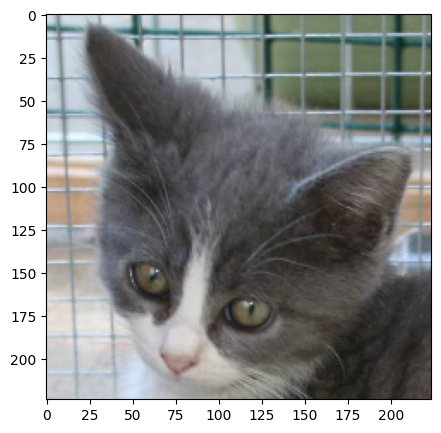

In [11]:
print(label)
plt.figure(figsize=(5,5))
plt.imshow(im.permute(1,2,0).cpu())
plt.show()

### 5. Define Model, Loss Function, Optimizer

In [12]:
def conv_layer(n_input, n_output, kernal_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(n_input,n_output, kernal_size,stride),
        nn.ReLU(),
        nn.BatchNorm2d(n_output),
        nn.MaxPool2d(2)
    )

In [13]:
def build_model():
    model = nn.Sequential(
        conv_layer(3,64,3),
        conv_layer(64,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        nn.Flatten(),
        nn.Linear(512,1),
        nn.Sigmoid(),
    ).to(device)
    
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    return model, loss_function, optimizer

In [14]:
from torchsummary import summary

In [15]:
model, loss_function, optimizer = build_model()

In [16]:
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

### 6. Define Data Preparation Function

In [17]:
def get_data():
    train = CatsDogs(train_data_dir)
    train_loader = DataLoader(train,batch_size=32,shuffle=True,drop_last=True)
    test = CatsDogs(test_data_dir)
    test_loader = DataLoader(test,batch_size=len(test),shuffle=True)
    
    return train_loader, test_loader

### 7. Define Model Training Function 

In [18]:
def train(x,y, model, loss_function,optimizer):
    model.train()
    predictions = model(x)
    batch_loss = loss_function(predictions,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    return batch_loss.item()

### 8. Calculate The Accuracy

In [19]:
@torch.no_grad()
def cal_accuracy(x,y,model):
    model.eval()
    predictions = model(x)
    is_correct = (predictions>0.5)==y
    
    return is_correct.cpu().numpy().tolist()

In [20]:
@torch.no_grad()
def val_loss(x,y,model, loss_function):
    model.eval()
    predictions = model(x)
    val_loss = loss_function(predictions,y)
    
    return val_loss.item()

### 9. Training the model for n epochs

In [21]:
train_dl , test_dl = get_data()

In [22]:
model, loss_function, optimizer = build_model()

In [ ]:
train_losses, train_accurcies = [],[]
test_losses, test_accurcies = [],[]
for epoch in range(10):
    
    print(f"Epoch: {epoch+1}")
    
    train_epoch_losses, train_epoch_accuracies = [],[]
    for ix, batch in enumerate(iter(train_dl)):
        x,y = batch 
        loss_value = train(x,y,model,loss_function,optimizer)
        print(ix,":", loss_value)
        train_epoch_losses.append(loss_value)
        
    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_losses.append(train_epoch_loss)
    print(f"Train Loss:{train_epoch_loss:0.3f}")
    
    
    for batch in (iter(train_dl)):
        x,y = batch
        is_correct = cal_accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    print(f"Train Accuracy:{train_epoch_accuracy*100:0.0f}%")
    
    for batch in (iter(test_dl)):
        x,y = batch 
        test_loss_value = val_loss(x,y,model,loss_function)
        test_accurcy = cal_accuracy(x,y,model)
    
    test_losses.append(test_loss_value)
    print(f"Test Loss: {test_loss_value:0.3f}")
    test_accurcies.append(test_accurcy)
    print(f"Test Accuracy:{test_accurcy*100:0.0f}%") 
    
    print("<------------------------------------------------------->")
          

Epoch: 1
0 : 0.7254647016525269
1 : 0.8641842603683472
2 : 1.2525274753570557
3 : 1.109872817993164
4 : 1.2085847854614258
5 : 1.091623067855835
6 : 0.6335146427154541
7 : 0.7129326462745667
8 : 0.7254274487495422
9 : 0.6990867853164673
10 : 0.8636798858642578
11 : 0.8974016904830933
12 : 0.7868924140930176
13 : 0.7187862396240234
14 : 0.7727458477020264
15 : 0.7431286573410034
16 : 0.6394929885864258
17 : 0.706084132194519
18 : 0.6559275984764099
19 : 0.6255836486816406
20 : 0.6236847639083862
21 : 0.737436056137085
22 : 0.7147683501243591
23 : 0.7280308604240417
24 : 0.6245236992835999
25 : 0.6530186533927917
26 : 0.6924702525138855
27 : 0.5752444267272949
28 : 0.7321208715438843
29 : 0.5916121006011963
30 : 0.5956894159317017
31 : 0.7188678979873657
32 : 0.7442531585693359
33 : 0.6959419250488281
34 : 0.7769778966903687
35 : 0.6931872367858887
36 : 0.6680125594139099
37 : 0.5941358804702759
38 : 0.7363476753234863
39 : 0.6363362073898315
40 : 0.8032917976379395
41 : 0.75003451108932

333 : 0.39027953147888184
334 : 0.539707601070404
335 : 0.49654579162597656
336 : 0.42735373973846436
337 : 0.4179821014404297
338 : 0.428348183631897
339 : 0.5257390737533569
340 : 0.3774629235267639
341 : 0.4031221866607666
342 : 0.40621834993362427
343 : 0.40424180030822754
344 : 0.41038691997528076
345 : 0.7414102554321289
346 : 0.5103808641433716
347 : 0.5172973871231079
348 : 0.5799739360809326
349 : 0.48714351654052734
350 : 0.3428551256656647
351 : 0.4453178346157074
352 : 0.5417186617851257
353 : 0.4713590145111084
354 : 0.5895670056343079
355 : 0.5267568826675415
356 : 0.396149218082428
357 : 0.42844879627227783
358 : 0.46229180693626404
359 : 0.5717728137969971
360 : 0.6135607361793518
361 : 0.46974432468414307
362 : 0.6984955072402954
363 : 0.568276047706604
364 : 0.47400152683258057
365 : 0.38038069009780884
366 : 0.48741060495376587
367 : 0.48663848638534546
368 : 0.41108447313308716
369 : 0.6338590383529663
370 : 0.4718857407569885
371 : 0.3760453462600708
372 : 0.805073

658 : 0.5052831768989563
659 : 0.19307345151901245
660 : 0.290449321269989
661 : 0.21051834523677826
662 : 0.3072029948234558
663 : 0.4348069429397583
664 : 0.24658796191215515
665 : 0.4190455377101898
666 : 0.18704845011234283
667 : 0.2946649491786957
668 : 0.38163819909095764
669 : 0.42716526985168457
670 : 0.5562474727630615
671 : 0.11339728534221649
672 : 0.3918488025665283
673 : 0.3218119740486145
674 : 0.2904551327228546
675 : 0.24485796689987183
676 : 0.30055052042007446
677 : 0.43531671166419983
678 : 0.25181883573532104
679 : 0.45393121242523193
680 : 0.40479403734207153
681 : 0.3591636121273041
682 : 0.12593258917331696
683 : 0.30127960443496704
684 : 0.5576530694961548
685 : 0.5057051777839661
686 : 0.7306495904922485
687 : 0.2716292440891266
688 : 0.3946394622325897
689 : 0.3755110502243042
690 : 0.34157854318618774
691 : 0.2512303590774536
692 : 0.18110916018486023
693 : 0.44802379608154297
694 : 0.1860732138156891
695 : 0.2794850468635559
696 : 0.6621519327163696
697 : 0.